<a href="https://colab.research.google.com/github/hihihi-svg/first-repl/blob/main/RLHF_SPEECH_SKETCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
noise_dim = 100
cond_dim = 5   # eye_size, openness, shape, tilt, eyebrow
image_size = (32, 64)  # H x W

In [ ]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # [-1, 1]
])


In [ ]:
DATASET_PATH = "/content/celeba-dataset/img_align_celeba/img_align_celeba"  # folder containing face images

image_paths = [
    os.path.join(DATASET_PATH, img)
    for img in os.listdir(DATASET_PATH)
    if img.lower().endswith((".jpg", ".png"))
]

print("Total images:", len(image_paths))

Total images: 202599


In [ ]:
import random

MAX_TRAIN = 1000
MAX_TEST = 150

random.shuffle(image_paths)

train_paths = image_paths[:MAX_TRAIN]
test_paths  = image_paths[MAX_TRAIN:MAX_TRAIN + MAX_TEST]

print("Train:", len(train_paths))
print("Test:", len(test_paths))


Train: 1000
Test: 150


In [ ]:
import os, cv2, random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


ModuleNotFoundError: No module named 'mediapipe'

In [ ]:
eye_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_eye.xml'
)

def crop_eyes_opencv(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)

    if len(eyes) == 0:
        return None

    # Take the largest eye region
    x, y, w, h = max(eyes, key=lambda e: e[2]*e[3])
    eye = gray[y:y+h, x:x+w]

    return Image.fromarray(eye)


In [ ]:
def extract_eye_features(eye_img):
    arr = np.array(eye_img)
    h, w = arr.shape

    # Eye size
    area = h * w
    eye_size = 2 if area > 1800 else 0 if area < 900 else 1

    # Openness
    openness = 0 if h/w < 0.35 else 2 if h/w > 0.55 else 1

    # Shape
    shape = 0 if w/h < 1.6 else 1  # round / almond

    # Tilt (ignored for now → neutral)
    tilt = 1

    # Eyebrow thickness (dark pixels)
    eyebrow = 2 if np.mean(arr[:int(h*0.2)]) < 100 else 1

    vec = torch.tensor([eye_size, openness, shape, tilt, eyebrow], dtype=torch.float32)
    return vec / 2.0


In [ ]:
crop_eyes=crop_eyes_opencv
class EyeDataset(Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # 👇 CROPPING HAPPENS HERE
        eye_img = crop_eyes_opencv(self.paths[idx])

        if eye_img is None:
            return self.__getitem__((idx + 1) % len(self.paths))

        # 👇 FEATURE EXTRACTION
        cond = extract_eye_features(eye_img)

        # 👇 TRANSFORM TO TENSOR
        img = self.transform(eye_img)

        return img, cond

In [ ]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = EyeDataset(train_paths, transform)
test_dataset  = EyeDataset(test_paths, transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
class EyeGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim + cond_dim, 512),
            nn.ReLU()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z, cond):
        x = torch.cat([z, cond], dim=1)
        x = self.fc(x)
        return self.net(x.view(-1, 512, 1, 1))

In [ ]:
class EyeDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d((4,4))
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4 + cond_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, img, cond):
        x = self.conv(img).view(img.size(0), -1)
        return self.fc(torch.cat([x, cond], dim=1))

In [ ]:
G = EyeGenerator().to(device)
D = EyeDiscriminator().to(device)

criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

EPOCHS = 100

for epoch in range(EPOCHS):
    for real, cond in train_loader:
        real, cond = real.to(device), cond.to(device)
        bs = real.size(0)

        valid = torch.ones(bs,1).to(device)
        fake  = torch.zeros(bs,1).to(device)

        # Generator
        z = torch.randn(bs, noise_dim).to(device)
        fake_img = G(z, cond)
        g_loss = criterion(D(fake_img, cond), valid)
        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()

        # Discriminator
        real_loss = criterion(D(real, cond), valid)
        fake_loss = criterion(D(fake_img.detach(), cond), fake)
        d_loss = (real_loss + fake_loss) / 2
        opt_D.zero_grad()
        d_loss.backward()
        opt_D.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | G:{g_loss.item():.3f} D:{d_loss.item():.3f}")

Epoch 0 | G:1.733 D:0.311
Epoch 10 | G:5.692 D:0.004
Epoch 20 | G:6.701 D:0.001
Epoch 30 | G:7.509 D:0.001
Epoch 40 | G:9.021 D:0.000
Epoch 50 | G:9.791 D:0.000
Epoch 60 | G:10.093 D:0.000
Epoch 70 | G:9.561 D:0.000
Epoch 80 | G:11.088 D:0.000
Epoch 90 | G:11.312 D:0.000


In [ ]:
def text_to_eye_features(text):
    text = text.lower()
    eye_size = 2 if "big" in text else 0 if "small" in text else 1
    openness = 0 if "narrow" in text else 2 if "wide" in text else 1
    shape = 0 if "round" in text else 1
    tilt = 1
    eyebrow = 2 if "thick" in text else 1
    return torch.tensor([eye_size, openness, shape, tilt, eyebrow]) / 2.0


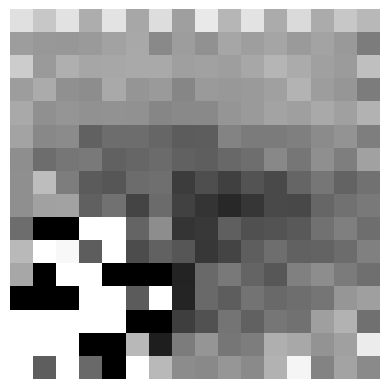

In [ ]:
G.eval()
cond = text_to_eye_features("big round eyes with thick eyebrows").unsqueeze(0).to(device)
z = torch.randn(1, noise_dim).to(device)

with torch.no_grad():
    img = G(z, cond)

plt.imshow(((img.squeeze().cpu()+1)/2), cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:08<00:00, 221MB/s]
100% 1.33G/1.33G [00:08<00:00, 166MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/celeba-dataset.zip', 'r')
zip_ref.extractall('/content/celeba-dataset')
zip_ref.close()

In [ ]:
TARGET_W = 256
PART_H = 85   # roughly 1/3 of 256

eyes = Image.open("eyes.png").resize((TARGET_W, PART_H))
nose = Image.open("nose.png").resize((TARGET_W, PART_H))
mouth = Image.open("mouth.png").resize((TARGET_W, PART_H))

In [ ]:
collage = Image.new("RGB", (TARGET_W, PART_H * 3), "white")

In [ ]:
collage.paste(eyes, (0, 0))                 # top
collage.paste(nose, (0, PART_H))            # middle
collage.paste(mouth, (0, PART_H * 2))       # bottom

collage.save("collaged_face.png")
collage


In [ ]:
#PIX2PIX GAN

In [ ]:
!pip install torch torchvision pillow matplotlib


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [ ]:
def load_image(path):
    img = Image.open(path).convert("RGB")
    return transform(img).unsqueeze(0).to(device)

collage = load_image("collaged_face.png")  # INPUT


FileNotFoundError: [Errno 2] No such file or directory: 'collaged_face.png'

In [ ]:
def load_image(path):
    img = Image.open(path).convert("RGB")
    return transform(img).unsqueeze(0).to(device)

collage = load_image("collaged_face.png")  # INPUT


FileNotFoundError: [Errno 2] No such file or directory: 'collaged_face.png'

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(6, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 1, 4, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        # x = collage, y = real or fake face
        return self.net(torch.cat([x, y], dim=1))


In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)


In [ ]:
criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
target_face = collage.clone()  # replace with real refined face later


NameError: name 'collage' is not defined

In [ ]:
valid = torch.ones((1, 1, 62, 62), device=device)
fake = torch.zeros((1, 1, 62, 62), device=device)

# ------------------
# Train Generator
# ------------------
optimizer_G.zero_grad()

fake_face = G(collage)

pred_fake = D(collage, fake_face)
loss_GAN = criterion_GAN(pred_fake, valid)
loss_L1 = criterion_L1(fake_face, target_face)

loss_G = loss_GAN + 100 * loss_L1
loss_G.backward()
optimizer_G.step()

# ------------------
# Train Discriminator
# ------------------
optimizer_D.zero_grad()

pred_real = D(collage, target_face)
loss_real = criterion_GAN(pred_real, valid)

pred_fake = D(collage, fake_face.detach())
loss_fake = criterion_GAN(pred_fake, fake)

loss_D = (loss_real + loss_fake) / 2
loss_D.backward()
optimizer_D.step()

print("Loss G:", loss_G.item(), "Loss D:", loss_D.item())


NameError: name 'collage' is not defined

In [ ]:
def show(tensor, title=""):
    img = tensor.squeeze().permute(1,2,0).cpu()
    img = (img + 1) / 2
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

show(collage, "Input Collage")
show(fake_face, "Generated Face")


NameError: name 'collage' is not defined